### Experiment 2.3.1
Testing grayworld as a model prior.

In [1]:
import tempfile
import zipfile
import urllib
import numpy as np
import torch
import pathlib
import torchvision as tv
import torchvision.datasets
import torchvision.transforms
import pandas as pd
from icecream import ic
import json
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits as mplt
import mpl_toolkits.axes_grid1
from collections import namedtuple
import ipyplot
import cv2
import einops
import PIL
import PIL.ImageCms
import IPython
import nncolor.colornet as colornet
import math
import re
import timm

Experiment 3.2.1 showed that preprocessing images with the grayworld algorithm improves the 
classification accuracy under certain illuminants. With this in mind, I thought it would be interesting to see the effect training a model that first calculates the average RGB pixel values and makes this available as 3 new input layers. 

## Hypothesis
Estimating illumination is useful for scene understanding, and by extension useful for classification. If illumination estimation requires taking in a large area of an image, then it will be many layers into the network before the receptive fields are large enough to perform effective illumination discounting. By giving the very first layer the average RGB values it might be possible to allow illumination discounting to occur much earlier in the network. It is hoped that this could lead to improved classification accuracy and improved illumination invariance.

## Model
The (``pytorch-image-models`)[https://github.com/rwightman/pytorch-image-models] library was cloned and the following type of change was made to a few different models, such as ResNet and fbnetv3. 

In [2]:
def forward_features(self, x):
    # [mod]
    mean =  torch.mean(x, dim=(2, 3), keepdim=True).expand(-1, -1, *x.shape[2:])
    x = torch.cat((x, mean), dim=1)
    # [/mod]
    # Also, self.conv1 had it's in-channel count doubled from 3 to 6 in the constructor.
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.act1(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

In [3]:
with open('./resources/imagenet-simple-labels.json') as f:
    labels = json.load(f)
    labels_to_id = {s:i for (i,s) in enumerate(labels)}
    
    
NUM_CLASSES = 1000
assert NUM_CLASSES == len(labels)
    
    
def class_id_to_label(cid):
    assert int(cid) == cid
    cid = int(cid)
    l = labels[cid]
    # This isn't a useful distinction for this experiment.
    # I don't even know what it is myself.
    if l == 'coffee mug':
        l = 'cup'
    return l


def label_to_class_id(label):
    # This isn't a useful distinction for this experiment.
    # I don't even know what it is myself.
    if label == 'coffee mug':
        label = 'cup'
    return labels_to_id[label]

In [4]:
def imshow(img):
    """Show image. 
    
    Image is a HWC numpy array with values in the range 0-1."""
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 
    
    
def imlist(images, labels=None, use_tabs=False):
    if use_tabs:
        ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=300)
    else:
        ipyplot.plot_images(images, labels)

In [5]:
# Choose CPU or GPU.
device = torch.device('cuda:1')
#device = "cpu"

# Choose small or large (standard) model variant
#model_name = 'colornet50_no_mixupcutmix'
#model_name = 'resnet50'
#model_name = 'fbnetv3grayworld_b_v2'
#model_name = 'fbnetv3grayworld_b_v2'
#model_name = 'fbnetv3_b'
model_name = 'fbnetv3grayworld3_b'
def model_fctn():
    model = None
    if model_name == 'resnet18':
        model = tv.models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        model = tv.models.resnet50(pretrained=True)
    elif model_name == 'colornet50':
        model = colornet.colornet50(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/colornet50.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'colornet50_no_mixupcutmix':
        model = colornet.colornet50(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/colornet50_no_mixup_no_cutmix.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'fbnetv3grayworld_b':
        model = timm.models.fbnetv3grayworld_b(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/fbnetv3grayworld_b.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'fbnetv3_b':
        model = timm.models.fbnetv3_b(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/fbnetv3_b.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'fbnetv3grayworld_b_v2':
        model = timm.models.fbnetv3grayworld_b(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/fbnetv3grayworld_b_v2.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'fbnetv3_b_v2':
        model = timm.models.fbnetv3_b(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/fbnetv3_b_v2.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'fbnetv3grayworld3_b':
        model = timm.models.fbnetv3grayworld3_b(pretrained=False)
        checkpoint_path = './resources/exp_2_1_3/fbnetv3grayworld3_b.pth.tar'
        timm.models.helpers.load_checkpoint(model, checkpoint_path)
    elif model_name == 'timm_resnet50':
        model = timm.models.resnet50(pretrained=True)
        #checkpoint_path = './resources/exp_2_1_3/timm_resnet50.pth.tar'
        #timm.models.helpers.load_checkpoint(model, checkpoint_path)
    return model
model = model_fctn()
#state = torch.hub.load_state_dict_from_url(tv.models.resnet.model_urls[model_name])
#model.load_state_dict(state)
model = model.to(device)
model.eval()


def model_name_str():
    """Returns the printable string form of the model."""
    res = None
    if model_name == 'resnet18':
        res = 'ResNet-18'
    elif model_name == 'resnet50':
        res = 'ResNet-50'
    else:
        raise Exception('Unexpected model.') 
    return res

IMG_SHAPE = (224, 224, 3)

In [6]:
ds_path = pathlib.Path('resources/exp_2/mls_dataset')
def is_empty(path):
    return not any(path.iterdir())
is_downloaded = ds_path.is_dir() and not is_empty(ds_path)
if not is_downloaded:
    ds_path.mkdir(exist_ok=True)
    zip_path, _ = urllib.request.urlretrieve('ftp://vis.iitp.ru/mls-dataset/images_preview.zip')
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(ds_path)

In [7]:
# Transforms
normalize_transform =  tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
crop = tv.transforms.FiveCrop(size=IMG_SHAPE[0])
pre_norm_transform = tv.transforms.Compose([crop])
norm_transform = tv.transforms.Compose([normalize_transform])

# Data details
num_scenes = 24
ignore_scenes = {1,} # 0: the Macbeth chart
scenes = [s for s in range(1, num_scenes+1) if s not in ignore_scenes]
crops = ['topleft', 'topright', 'bottomleft', 'bottomright', 'center']
Crop = namedtuple('Crop', 'y, x, h, w')
Scene = namedtuple('Scene', 'imagenet_label, id, crop') 
# Choose a crop size that allows for 5 sub-crops of size 224.
crop_size = int(224 * 3/2) # 336 
scenes = [
    Scene('bath towel',      11, Crop(157, 264, crop_size, crop_size)),
    Scene('ping-pong ball',  12, Crop(230, 110, 263,       292)),       # Image made smaller to keep ball in all crops.
    Scene('cup',             13, Crop(157,   0, crop_size, crop_size)), # Not sure if 'cup' or 'coffee mug' is the best class.
    Scene('pot',             14, Crop(117,  50, crop_size, crop_size)), 
    Scene('Granny Smith',    15, Crop(185, 264, crop_size, crop_size)), 
    Scene('bell pepper',     16, Crop(157, 216, crop_size, crop_size)), 
    Scene('banana',          17, Crop(157,   0, crop_size, crop_size)), # This image also contains an orange and apple.
    Scene('cup',             20, Crop(197,  15, 296,       crop_size)), # Image made to keep the cup in all crops.
    Scene('water bottle',    22, Crop( 65, 264, crop_size, crop_size)), 
    Scene('water bottle',    24, Crop(20,   0, crop_size, crop_size)), # This image also contains a banana.
    Scene('banana',          24, Crop(197,  50, 296,       crop_size))] # This image also contains a water bottle.
illuminants = [
    '2HAL_DESK_LED-B025',
    '2HAL_DESK_LED-B050',
    '2HAL_DESK_LED-B075',
    '2HAL_DESK_LED-B100',
    '2HAL_DESK_LED-BG025',
    '2HAL_DESK_LED-BG050',
    '2HAL_DESK_LED-BG075',
    '2HAL_DESK_LED-BG100',
    '2HAL_DESK_LED-R025',
    '2HAL_DESK_LED-R050',
    '2HAL_DESK_LED-R075',
    '2HAL_DESK_LED-R100',
    '2HAL_DESK_LED-RG025',
    '2HAL_DESK_LED-RG050',
    '2HAL_DESK_LED-RG075',
    '2HAL_DESK_LED-RG100',
    '2HAL_DESK',
    '2HAL']


def img_key(scene_id, imagenet_label, crop_label, illuminant):
    return f'{scene_id}.{imagenet_label}.{crop_label}.{illuminant}'


def rec_2020_to_sRGB(rgb_img):
    """Convert image in REC2020 linear colorspace to an sRGB colorspace image.
    
    This method didn't actually seem to work, yet I'm not exactly sure why, so 
    I'm keeping it here so I can come back and try understand why it isn't working. 
    Below, I ended up using the inbuilt features of PIL instead.
    """
    # Rec 2020 to CIE XYZ
    to_xyz_mat = torch.tensor([[6.36953507e-01, 1.44619185e-01, 1.68855854e-01], 
                               [2.62698339e-01, 6.78008766e-01, 5.92928953e-02], 
                               [4.99407097e-17, 2.80731358e-02, 1.06082723e+00]])
    def dot_vector(m, v):
        return  torch.einsum('...ij,...j->...i', m, v)
    xyz = dot_vector(to_xyz_mat, rgb_img)
    
    # CIE XYZ to sRGB
    to_linear_rgb_mat = torch.tensor([
        [3.2406, -1.5372, -0.4986],
        [-0.9689, 1.8758, 0.0415],
        [0.0557, 0.2040, 1.057]])
    linear_rgb = dot_vector(to_linear_rgb_mat, xyz)
    
    def to_srgb(c):
        res = 12.92*c if c <= 0.0031308 else (1.055 * c**(1/2.4) - 0.055)
        return res
    s_rgb = linear_rgb.apply_(to_srgb)
    s_rgb_chw = einops.rearrange(s_rgb, 'h w c -> c h w')
    return s_rgb_chw


def open_as_srgb(img_path):
    """Open an image and convert it to sRGB.
    
    The image must have an embedded ICC color profile."""
    img = PIL.Image.open(img_path)
    icc = tempfile.mkstemp(suffix='.icc')[1]
    with open(icc, 'wb') as f:
        f.write(img.info.get('icc_profile'))
    srgb = PIL.ImageCms.createProfile('sRGB')
    img = PIL.ImageCms.profileToProfile(img, icc, srgb)
    return img

def mixed_pass(img):
    blurred0 = cv2.GaussianBlur(img,  (999, 999), 400, 400)
    blurred1 = cv2.GaussianBlur(img,  (999, 999), 30, 30)
    #blurred = np.array(blurred, dtype=np.float32)
    t0 = 0.05
    t1 =  0.9
    hp = img*t0 + (1-t0)*(img - blurred0 + 127.0)
    hp = hp*t1 + (1-t1)*(0.5*(hp + blurred1))
    hp = np.clip(hp, 0, 255.0)
    return hp

def grayworld_correct_2(img, power=6, gamma=2.2):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256, 1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i / 255, 1 / gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0, 1)), 1 / power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec / rgb_norm
    rgb_vec = 1 / (rgb_vec * np.sqrt(3))
    img = np.multiply(img, rgb_vec)
    img = np.clip(img, a_min=0, a_max=255)
    return img.astype(img_dtype)

def grayworld_correct(img, strength=1.0):
    img = img.astype('uint8')
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 127) * (result[:, :, 0] / 255.0) * 1.1 * strength)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 127) * (result[:, :, 0] / 255.0) * 1.1 * strength)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    result = np.clip(result.astype('float32'), 0, 255.0) 
    return result
    
def open_img(scene, illuminant):
    """Open the image corresponding to the given scene and illuminant."""
    img_path = ds_path / 'images_preview' / f'{scene.id:02d}' / f'{scene.id:02d}_{illuminant}.jpg'
    img = open_as_srgb(img_path) 
    img = np.array(img, dtype=np.float32)
    cropped = img[scene.crop.y:scene.crop.y+scene.crop.h, scene.crop.x:scene.crop.x+scene.crop.w, :]
    return cropped


def create_dataset(filter=False):
    """
    Dataset as a dict. Keys are of the form: 04-topleft-2HAL_DESK_LED-B025.
    Images are 0-1 tensors.
    """
    images = dict()
    for s in scenes:
        for ill in illuminants:
            img = open_img(s, ill)
            #img = np.asarray(img, dtype=np.float32) / 255.0
            img = np.asarray(img, dtype=np.float32)
            #img = high_pass_filter(img)
            if filter:
                #img = mixed_pass(img)
                img = grayworld_correct(img, strength=1.0)
            img = img / 255.0
            img = torch.tensor(einops.rearrange(img, 'h w c -> c h w'))
            cropped_images = pre_norm_transform(img)
            for crop_label, ci in zip(crops, cropped_images):
                images[img_key(s.id, s.imagenet_label, crop_label, ill)] = ci
    return images

In [8]:
def get_ds_image(ds, scene, illuminant, subcrop):
    # img is torch in CxHxW format.
    img = ds[img_key(scene.id, scene.imagenet_label, subcrop, illuminant)]
    img = einops.rearrange(img, 'c h w -> h w c').numpy()
    return img


def print_originals():
    """Print the images before the 5-crop transformation.
    
    Only images for one illumination are printed."""
    images = []
    labels = []
    for s in scenes:
        img = open_img(s, illuminants[-2])
        labels.append(s.imagenet_label)
        images.append(img)
    imlist(images, labels)
            
def print_single_illuminant(illuminant = '2HAL_DESK_LED-RG075'):
    """Print images for 1 illuminant before 5-crop, using matplotlib."""
    fig = plt.figure(figsize=(12, 11))
    num_scenes = len(scenes)
    cols = 4
    rows = math.ceil(num_scenes / cols)
    for idx, s in enumerate(scenes):
        ax = fig.add_subplot(rows, cols, idx+1)
        ax.set_axis_off()
        ax.set_anchor('N')
        ax.set_title(s.imagenet_label.lower(), loc='center')
        ax.imshow(open_img(s, illuminant)/255)
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    plt.savefig("./out/report/mls_all_scenes.pdf", format="pdf", bbox_inches="tight")
    fig.show()
    
def print_single_scene(scene_idx=5):
    """Print images for 1 scene before 5-crop, using matplotlib."""
    fig = plt.figure(figsize=(20, 10))
    num_illum = len(illuminants)
    cols = 6
    rows = math.ceil(num_illum / cols)
    for idx, ill in enumerate(illuminants):
        ax = fig.add_subplot(rows, cols, idx+1)
        ax.set_axis_off()
        ax.imshow(open_img(scenes[scene_idx], ill)/255)
    fig.subplots_adjust(hspace=0.05, wspace=0.02)
    fig.show()
        
def print_single_scene2(scene_idx=5):
    """Print images for 1 scene before 5-crop, using matplotlib."""
    fig = plt.figure(figsize=(12, 20))
    num_illum = len(illuminants)
    cols = 3
    rows = math.ceil(num_illum / cols)
    for idx, ill in enumerate(illuminants):
        ax = fig.add_subplot(rows, cols, idx+1)
        ax.set_axis_off()
        ax.set_title(re.sub('_', '-', ill), loc='center', fontsize=18)
        ax.imshow(open_img(scenes[scene_idx], ill)/255)
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    plt.savefig("./out/report/mls_all_illuminants_details.pdf", format="pdf", bbox_inches="tight")
    fig.show()
    
def print_correction_comparison():
    """Print images for 1 illuminant before 5-crop, using matplotlib."""
    fig = plt.figure(figsize=(20, 7))
    cols = 6
    rows = 2
    s = scenes[5]
    for i in range(cols):
        ax_top = fig.add_subplot(rows, cols, i+1)
        ax_bottom = fig.add_subplot(rows, cols, i+cols+1)
        ax_top.set_axis_off()
        ax_bottom.set_axis_off()
        ax_top.imshow(open_img(s, illuminants[i*2])/255)
        ax_bottom.imshow(grayworld_correct(open_img(s, illuminants[i*2]), strength=1.5)/255)
    fig.subplots_adjust(hspace=0.00, wspace=0.10)
    plt.savefig("./out/report/mls_grayworld_comparison.pdf", format="pdf", bbox_inches="tight")

def print_dataset(ds, inc_illuminants=None):
    """Print the dataset images.
    
    Args:
        inc_illuminants (set): restrict the illuminants to this set. Without
                               setting this option, the number of images printed
                               with be quite large (11x5x18).
   """
    if not inc_illuminants:
        inc_illuminants = set(illuminants)
    tab_labels = []
    images = []
    custom_labels = []
    for k,v in ds.items():
        sid, imagenet_label, crop, illuminant = k.split('.')
        if not illuminant in inc_illuminants:
            continue
        tab_labels.append(illuminant)
        images.append(einops.rearrange(v.numpy(), 'c h w -> h w c'))
        custom_labels.append(f'{imagenet_label} ({crop})')
        
    ipyplot.plot_class_tabs(images, tab_labels, custom_labels, max_imgs_per_tab=200)

## 2. Method
Same as experiment 2.0.0. 

Pass each of the 11x18x5 (11 scenes, 18 illuminations, 5 crops) preview images
into a ResNet model for classification. The ResNet model is pretrained for 
ImageNet classification. Record every classification. 

In [10]:
def run_all_images_through_ResNet(ds):
    """Input the images into the ResNet model and collect results.
    
    Returns: results as an xarray.DataArray.
    """
    raw_data = np.zeros((len(scenes), len(crops), len(illuminants), NUM_CLASSES))
    classification_val_id_pairs = []
    for idx, s in enumerate(scenes): 
        for crop_idx, crop in enumerate(crops):
            classification_ids = []
            for ill_idx, ill in enumerate(illuminants):
                img = ds[img_key(s.id, s.imagenet_label, crop, ill)]
                input_ = torch.unsqueeze(normalize_transform(img), 0).to(device)
                model_out = model.forward(input_)
                raw_data[idx][crop_idx][ill_idx][:] = model_out.squeeze().detach().cpu()
    xdata = xr.DataArray(raw_data,  
                         coords={'scene':range(len(scenes)), 'crop':crops,  'illuminant':illuminants, 
                                 'class_id':np.arange(0, NUM_CLASSES)})
    return xdata
#ds_mod =  create_dataset(filter=True)
ds_orig =  create_dataset(filter=False)
data_orig = run_all_images_through_ResNet(ds_orig)
#data_mod = run_all_images_through_ResNet(ds_mod)
#data_orig.to_netcdf('./resources/exp_2_1_3/fbnetv3grayworld3_b.cdf')
#data_mod = run_all_images_through_ResNet(ds_mod)
#data_mod.to_netcdf('./resources/exp_2_1_3/fbnetv3grayworld3_b_filter_enabled.cdf')
#data_orig.to_netcdf('./resources/exp_2_1_3/timm_resnet50_classifications.cdf')
data_resnet50_orig = xr.open_dataarray('./resources/exp_2_1_3/resnet50_classifications.cdf')
data_timm_resnet50_orig = xr.open_dataarray('./resources/exp_2_1_3/timm_resnet50_classifications.cdf')
data_fbv3grayworld_b = xr.open_dataarray('./resources/exp_2_1_3/fbnetv3grayworld_b.cdf')
data_fbv3_b = xr.open_dataarray('./resources/exp_2_1_3/fbnetv3_b.cdf')
data_fbv3grayworld3_b = xr.open_dataarray('./resources/exp_2_1_3/fbnetv3grayworld3_b.cdf')

In [11]:
# Organise the data into some useful formats. 
# These results are used throughout the rest of the notebook. 
#
def is_equal_groundtruth(d):
    classifications = d.argmax(dim='class_id')
    res = []
    for idx, group in classifications.groupby('scene'):
        res.append(xr.where(group == label_to_class_id(scenes[idx].imagenet_label), True, False))
    res = xr.concat(res, dim='scene')
    return res

### Effect of illuminants
The above figure is transformed by summing along the x-axis 
(scene-crop axis disappears). The illumination axis stays the same. The x-axis
becomes a count.
Below is a figure with the number of successful classifications summed across scenes and crops, then plotted against illumination. From this we see that actually, there _is_ quite a difference between the different illuminants. The cube above is thus not a great visualization.

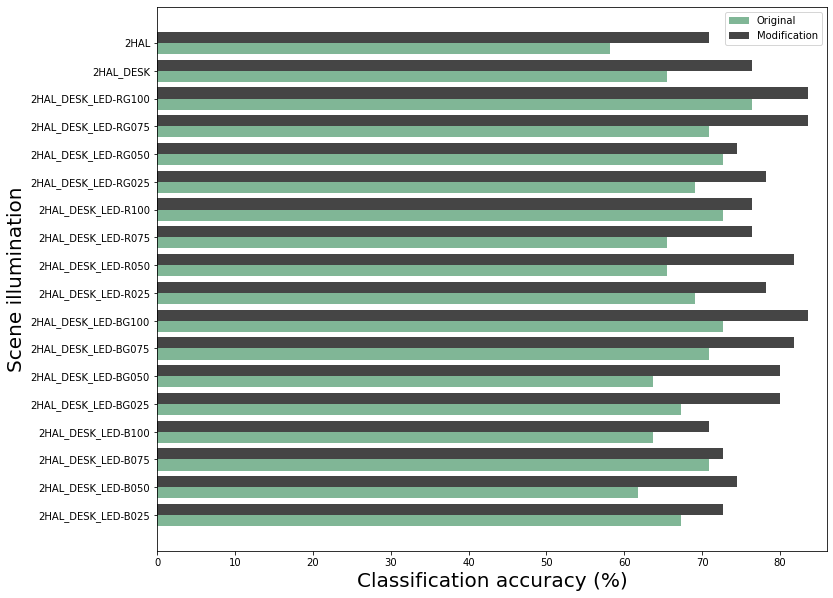

In [14]:
def plot_accuracy_by_illuminant(res_by_illuminant, res_by_illuminant2=None):
    #ans.plot()
    blue = '#A3E6E6'
    blue = '#006D9B'
    green = '#80b696'
    blue = '#454545'
    fig, ax = plt.subplots(figsize=(12,10))
    #ax.set_title(f'Correct classification counts for {model_name_str()} under different illumination')
    axis_label_font_size = 20
    ax.set_ylabel('Scene illumination', fontsize=axis_label_font_size)
    ax.set_xlabel('Classification accuracy (%)', fontsize=axis_label_font_size)
    ax.set_yticks(np.arange(0, len(illuminants)))
    ax.set_xlim(0, 86)
    ax.minorticks_off()
    y_tick_labels = illuminants
    num_per_illuminant = 55
    ax.set_yticklabels(y_tick_labels)#, fontsize=20)
    if res_by_illuminant2 is None:
        accuracy = res_by_illuminant.data / num_per_illuminant * 100
        ax.barh(np.arange(len(illuminants)), accuracy, color=green)
    else:
        width = 0.40
        gap = 0.1
        accuracy1 = res_by_illuminant.data / num_per_illuminant * 100
        ax.barh(np.arange(len(illuminants)) - width/2, accuracy1, width, color=green, label='Original')
        accuracy2 = res_by_illuminant2.data / num_per_illuminant * 100
        ax.barh(np.arange(len(illuminants)) + width/2, accuracy2, width, color=blue, label='Modification')
        ax.legend()
    plt.savefig(f"./out/report/mls_accuracy_fbnetv3_grayworld_b.pdf", format="pdf", bbox_inches="tight")
    fig.show()
 
by_illuminant_orig = is_equal_groundtruth(data_orig).sum(dim=['scene', 'crop'])
#by_illuminant_mod = is_equal_groundtruth(data_mod).sum(dim=['scene', 'crop'])
by_illuminant_resnet50_orig = is_equal_groundtruth(data_resnet50_orig).sum(dim=['scene', 'crop'])
by_illuminant_timm_resnet50_orig = is_equal_groundtruth(data_timm_resnet50_orig).sum(dim=['scene', 'crop'])
by_illuminant_fbv3grayworld_b = is_equal_groundtruth(data_fbv3grayworld_b).sum(dim=['scene', 'crop'])
by_illuminant_fbv3grayworld3_b = is_equal_groundtruth(data_fbv3grayworld3_b).sum(dim=['scene', 'crop'])
by_illuminant_fbv3_b = is_equal_groundtruth(data_fbv3_b).sum(dim=['scene', 'crop'])
plot_accuracy_by_illuminant(
    #by_illuminant_orig, 
    by_illuminant_fbv3_b,
    #by_illuminant_mod) 
    #by_illuminant_fbv3grayworld_b,
    by_illuminant_fbv3grayworld3_b)